# Generate dataset of FRB/Star images

This notebook generates a dataset of images simulating either FRB or point-source through the atmosphere and the Rubin-LSST Telescope.

Import relevant python packages:

In [1]:
import trace
from tqdm.notebook import trange, tqdm
import galsim
import pickle
import matplotlib.pyplot as plt
import numpy as np
import glob
import multiprocessing as mp
import random
from numba import jit, cuda

# Define wavelength dictionary
wavelength_dict = dict(
    u = 365.49,
    g = 480.03,
    r = 622.20,
    i = 754.06,
    z = 868.21,
    y = 991.66
)

# Define the observation parameters.
observation = {
    'boresight': galsim.CelestialCoord(
        30*galsim.degrees, 10*galsim.degrees
    ),
    'zenith': 30*galsim.degrees,
    'airmass': 1.1547,
    'rotTelPos': 0.0*galsim.degrees,  # zenith measured CCW from up
    'rotSkyPos': 0.0*galsim.degrees,  # N measured CCW from up
    'rawSeeing': 0.7*galsim.arcsec,
    'band': 'i',
    'exptime': 15.0,
    'frbtime': 0.005,
    'temperature': 293.15,  # K
    'pressure': 69.328,  # kPa
    'H2O_pressure': 1.067,  # kPa
}

# Set the wavelenght from the observation band. 
wavelength = wavelength_dict[observation['band']]

In [5]:
def update(*a):
    pbar.update()
    pbar.refresh()
    
class Arguments:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
      
def generate_dataset(it, args):
    print('in here')
    np.random.seed(int(it*1000*np.random.random()))
    rng = galsim.BaseDeviate()
    traced_photons, wavelengths = trace.tracePhotons(args.num_phot, rng, args.observation, args.wavelength, args.atmosphere, args.duration)
    print('hehe')
    PIXEL_SIZE = 10e-6
    STAMP_SIZE = 10
    SKY_LEVEL = 1000.0
    image_array = trace.generateImage(traced_photons, wavelengths, STAMP_SIZE, PIXEL_SIZE, SKY_LEVEL)

    plt.imsave(f'{args.folder}/FOB_{args.duration_label}_{args.num_phot}_{it + args.offset}.png', image_array)
    np.save(f'{args.folder}/FOB_{args.duration_label}_{args.num_phot}_{it + args.offset}.npy', image_array)
    np.savetxt(f'{args.folder}/FOB_{args.duration_label}_{args.num_phot}_{it + args.offset}.txt', image_array, delimiter=',')  
   

def generate_dataset_parallel(argums, pbar):
    pool = mp.Pool(mp.cpu_count())
    
    pbar.reset(total=argums.num_simulations) 
    for it in range(argums.num_simulations):
        
        pool.apply_async(
            generate_dataset, 
            args = (it, argums), 
            callback = update
        )

    pool.close()
    pool.join()
    
    # Close progressbar
    pbar.close()

In [6]:
import time
# The line below sets the environment
# variable OMP_NUM_THREADS
%env OMP_NUM_THREADS=1

# Load atmosphere phase screen list created from Elleboerk model.
with open("policy/full_atm.pkl", 'rb') as f:
    full_atm = pickle.load(f)
    
# Load atmosphere phase screen list created from Elleboerk model.
with open("policy/truncated_atm.pkl", 'rb') as f:
    truncated_atm = pickle.load(f)

env: OMP_NUM_THREADS=1


In [8]:
pbar = tqdm(total = 2000)

generate_dataset_parallel(
    Arguments(
        atm = full_atm,
        duration = 0.015,
        duration_label = '15ms',
        num_simulations =  10,
        num_phot = int(7.5e5),
        observation = observation,
        atmosphere = full_atm,
        wavelength = wavelength,
        folder = 'data',
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

in herein herein herein here


in here
in here

in herein here
in here

in here


## 2. Generate datasets for different star configuration

In [7]:
%%time
durs = [0.01]
durats = ['10ms']

for idx in  range(len(durats)):

    print(f' ------------ {durats[idx]} ------------')
    for inten in [3e5]:
        # Create progress bar
        pbar = tqdm(total = 2000)

        # Generate dataset
        generate_dataset_parallel(
            Arguments(
                name = 'FRB',
                method = 'FFT',
                atm = full_atm,
                duration = durs[idx],
                duration_label = durats[idx],
                num_simulations =  10,
                num_phot = int(inten),
                offset = 0
            ),
            pbar
        )

 ------------ 10ms ------------


  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 77.3 ms, sys: 126 ms, total: 203 ms
Wall time: 268 ms


In [9]:
durs = [0.01, 0.15, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
durs = [0.08, 0.1]
durats = ['80ms', '100ms']



for idx in  range(len(durats)):

    print(f' ------------ {durats[idx]} ------------')
    for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4]:
        # Create progress bar
        pbar = tqdm(total = 2000)

        # Generate dataset
        generate_dataset_parallel(
            Arguments(
                name = 'FRB',
                method = 'FFT',
                atm = full_atm,
                duration = durs[idx],
                duration_label = durats[idx],
                num_simulations = 2000,
                num_phot = int(inten),
                offset = 2000
            ),
            pbar
        )

 ------------ 80ms ------------


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

: 

: 

: 

: 

: 

: 

In [10]:
%%time
durs = [0.15, 0.2, 0.4]
durats = ['150ms', '200ms', '400ms']

for idx in  range(len(durats)):

    print(f' ------------ {durats[idx]} ------------')
    for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
        # Create progress bar
        pbar = tqdm(total = 2000)

        # Generate dataset
        generate_dataset_parallel(
            Arguments(
                name = 'FRB',
                method = 'FFT',
                atm = full_atm,
                duration = durs[idx],
                duration_label = durats[idx],
                num_simulations = 2000,
                num_phot = int(inten),
                offset = 0
            ),
            pbar
        )

 ------------ 150ms ------------


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

 ------------ 200ms ------------


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

 ------------ 400ms ------------


  0%|          | 0/2000 [00:00<?, ?it/s]

Process ForkPoolWorker-13862:
Process ForkPoolWorker-13800:
Process ForkPoolWorker-13754:
Process ForkPoolWorker-13732:
Process ForkPoolWorker-13842:
Process ForkPoolWorker-13846:
Process ForkPoolWorker-13817:
Process ForkPoolWorker-13735:
Process ForkPoolWorker-13804:
Process ForkPoolWorker-13863:
Process ForkPoolWorker-13849:
Process ForkPoolWorker-13762:
Process ForkPoolWorker-13834:
Process ForkPoolWorker-13816:
Process ForkPoolWorker-13812:
Process ForkPoolWorker-13819:
Process ForkPoolWorker-13776:
Process ForkPoolWorker-13851:
Process ForkPoolWorker-13878:
Process ForkPoolWorker-13743:
Process ForkPoolWorker-13847:
Process ForkPoolWorker-13793:
Process ForkPoolWorker-13748:
Process ForkPoolWorker-13818:
Process ForkPoolWorker-13770:
Process ForkPoolWorker-13821:
Process ForkPoolWorker-13840:
Process ForkPoolWorker-13731:
Process ForkPoolWorker-13737:
Process ForkPoolWorker-13880:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-13729:


  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-13881:
Process ForkPoolWorker-13882:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-13884:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-13839:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._ar

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

Process ForkPoolWorker-13771:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-13858:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    

  File "/tmp/ipykernel_5397/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_5397/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/tmp/ipykernel_5397/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_5397/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/tmp

  File "/tmp/ipykernel_5397/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_5397/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/guillemmh/FOBs/trace_dataset.py", line

  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerings(r_max = 1e7)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/tmp/ipykernel_5397/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_5397/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/home/guillemmh/FOBs/trace.py", line 240, in tracePhotons
    first_kick
  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerin

  File "/home/guillemmh/FOBs/trace.py", line 182, in GalsimToBatoid
    vz /= n
  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerings(r_max = 1e7)
  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerings(r_max = 1e7)
  File "/home/guillemmh/FOBs/trace.py", line 245, in tracePhotons
    rays = GalsimToBatoid(u, v, dku, dkv, telescope, wavelengths, phot_num_tot)
  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerings(r_max = 1e7)
  File "/home/guillemmh/FOBs/trace.py", line 245, in tracePhotons
    rays = GalsimToBatoid(u, v, dku, dkv, telescope, wavelengths, phot_num_tot)
  File "/home/guillemmh/FOBs/trace.py", line 178, in GalsimToBatoid
    n.append(telescope.inMedium.getN(wavelengths[idx]))
  File "/tmp/ipykernel_5397/213037740.py", line 21, in generate_dataset2
    nois

  File "/tmp/ipykernel_5397/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/home/guillemmh/FOBs/trace_dataset.py", line 28, in tracePhotons
    frb_photons = frb_atm_psf.shoot(num_phot, rng)
Process ForkPoolWorker-13745:
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_5397/213037740.py", line 21, in generate_dataset2
    noise = False,
Process ForkPoolWorker-13835:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multip

  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 452, in simple_treerings
    return LookupTable.from_func(func, x_min=0., x_max=r_max, npoints=npoints)
  File "/opt/conda/lib/python3.7/site-packages/galsim/phase_psf.py", line 1554, in _shoot
    self._prepareDraw()
  File "/home/guillemmh/FOBs/trace_dataset.py", line 28, in tracePhotons
    frb_photons = frb_atm_psf.shoot(num_phot, rng)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_5397/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/opt/conda/lib/python3.7/site-packages/galsim/table.py", line 502, in from_func
    f = np.array([func(xx) for xx in x], dtype=float)
  File "/tmp/ipykernel_5397/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths 

  File "/tmp/ipykernel_5397/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/site-packages/galsim/table.py", line 502, in from_func
    f = np.array([func(xx) for xx in x], dtype=float)
  File "/opt/conda/lib/python3.7/site-packages/galsim/phase_psf.py", line 1554, in _shoot
    self._prepareDraw()
  File "/opt/conda/lib/python3.7/site-packages/galsim/phase_psf.py", line 1554, in _shoot
    self._prepareDraw()
  File "/tmp/ipykernel_5397/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerings(r_max = 1e7)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py",

  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 452, in simple_treerings
    return LookupTable.from_func(func, x_min=0., x_max=r_max, npoints=npoints)
  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerings(r_max = 1e7)
  File "/opt/conda/lib/python3.7/site-packages/galsim/table.py", line 502, in <listcomp>
    f = np.array([func(xx) for xx in x], dtype=float)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 452, in simple_treerings
    return LookupTable.from_func(func, x_min=0., x_max=r_max, npoints=npoints)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 452, in simple_treerings
    return LookupTable.from_func(func, x_min=0., x_max=r_max, npoints=npoints)
  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerings(r_max = 1e7)
  File "/tmp/ipykernel_5397/213037740.py", line 21

KeyboardInterrupt
  File "/opt/conda/lib/python3.7/site-packages/batoid/optic.py", line 829, in trace
    item.trace(rv, reverse=reverse)
  File "/opt/conda/lib/python3.7/site-packages/galsim/table.py", line 502, in <listcomp>
    f = np.array([func(xx) for xx in x], dtype=float)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/galsim/phase_psf.py", line 1455, in _prepareDraw
    self._screen_list._prepareDraw()
  File "/home/guillemmh/FOBs/trace.py", line 249, in tracePhotons
    traced_rays = TelescopeTrace(rays, telescope)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 448, in <lambda>
    func = lambda r: amplitude * np.cos(k * r)
  File "/opt/conda/lib/python3.7/site-packages/galsim/table.py", line 502, in <listcomp>
    f = np.array([func(xx) for xx in x], dtype=float)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", li

  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerings(r_max = 1e7)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_5397/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/galsim/phase_psf.py", line 673, in _sky_scale
    return (lam*1e-9) / self.pupil_plane_size * radians/scale_unit
  File "/tmp/ipykernel_5397/1976484744.py", line 20, in generateImage
    treering_func = galsim.SiliconSensor.simple_treerings(r_max = 1e7)
  File "/home/guillemmh/FOBs/trace_dataset.py", line 28, in tracePhotons
    frb_photons =

  File "/opt/conda/lib/python3.7/site-packages/galsim/phase_psf.py", line 1455, in _prepareDraw
    self._screen_list._prepareDraw()
  File "/home/guillemmh/FOBs/trace_dataset.py", line 75, in tracePhotons
    traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, atm, first_kick = first_kick)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 452, in simple_treerings
    return LookupTable.from_func(func, x_min=0., x_max=r_max, npoints=npoints)
  File "/opt/conda/lib/python3.7/site-packages/galsim/table.py", line 502, in from_func
    f = np.array([func(xx) for xx in x], dtype=float)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 452, in simple_treerings
    return LookupTable.from_func(func, x_min=0., x_max=r_max, npoints=npoints)
  File "/home/guillemmh/FOBs/trace_dataset.py", line 75, in tracePhotons
    traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, atm, fi

In [7]:
%%time
for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.010,
            duration_label = '10ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 1min 34s, sys: 42 s, total: 2min 16s
Wall time: 4h 26min 26s


In [26]:
%%time
for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 15,
            duration_label = '15s',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 14min 47s, sys: 15min 11s, total: 29min 58s
Wall time: 17h 49min 29s


In [10]:
for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.020,
            duration_label = '20ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
for inten in [3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.040,
            duration_label = '40ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
%%time

for inten in [8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.060,
            duration_label = '60ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 51.7 s, sys: 22.7 s, total: 1min 14s
Wall time: 24min 23s


In [8]:
%%time

for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.080,
            duration_label = '80ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 1min 57s, sys: 1min 3s, total: 3min
Wall time: 1h 46min 48s


In [9]:
%%time
for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.100,
            duration_label = '100ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 2min, sys: 1min 5s, total: 3min 5s
Wall time: 1h 47min 37s


In [10]:
%%time
for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.120,
            duration_label = '120ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

Process ForkPoolWorker-3179:
Process ForkPoolWorker-3131:
Process ForkPoolWorker-3158:
Process ForkPoolWorker-3237:
Process ForkPoolWorker-3250:
Process ForkPoolWorker-3249:
Process ForkPoolWorker-3150:
Process ForkPoolWorker-3181:
Traceback (most recent call last):
Process ForkPoolWorker-3255:
Process ForkPoolWorker-3151:
Process ForkPoolWorker-3208:
Process ForkPoolWorker-3157:
Process ForkPoolWorker-3127:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-3134:
Process ForkPoolWorker-3125:
Process ForkPoolWorker-3227:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/mu

  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/guillemmh/FOBs/trace_dataset.py", line 75, in tracePhotons
    traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, atm, first_kick = first_kick)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/guillemmh/FOBs/trace_dataset.py", line 75, in tracePhotons
    traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, atm, first_kick = first_kick)
  File "/tmp/ipykernel_3851/2

  File "/home/guillemmh/FOBs/trace_dataset.py", line 75, in tracePhotons
    traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, atm, first_kick = first_kick)
  File "/opt/conda/lib/python3.7/site-packages/galsim/phase_psf.py", line 1554, in _shoot
    self._prepareDraw()
  File "/opt/conda/lib/python3.7/site-packages/batoid/medium.py", line 24, in getN
    return self._medium.getN(wavelength)
  File "/tmp/ipykernel_3851/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/tmp/ipykernel_3851/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/home/guillemmh/FOBs/trace.py", line 178, in GalsimToBatoid
    n.append(telescope.inMedium.getN(wavelengths[idx]))

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/batoid/rayVector.py", line 55, in __init__
    shape
  File "/home/guillemmh/FOBs/trace.py", line 199, in TelescopeTrace
    rays_traced = telescope.trace(rays)
  File "/tmp/ipykernel_3851/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/opt/conda/lib/python3.7/site-packages/galsim/interpolatedimage.py", line 584, in _getMaxK
    self._sbii.calculateMaxK(0.)
  File "/home/guillemmh/FOBs/trace.py", line 199, in TelescopeTrace
    rays_traced = telescope.trace(rays)
  File "/opt/conda/lib/python3.7/site-packages/batoid/rayVector.py", line 18, in _reshape_arrays
    arrays[i] = np.array(np.broadcast_to(array, shape))
KeyboardInterrupt
  File "<__array_function__ internals

  File "/opt/conda/lib/python3.7/site-packages/batoid/surface.py", line 79, in reflect
    return reflect(self, rv, coordSys, coating)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/opt/conda/lib/python3.7/site-packages/batoid/optic.py", line 829, in trace
    item.trace(rv, reverse=reverse)
  File "/opt/conda/lib/python3.7/site-packages/batoid/optic.py", line 571, in interact
    return self.surface.refract(rv, m1, m2, coordSys=self.coordSys)
  File "/home/guillemmh/FOBs/trace.py", line 245, in tracePhotons
    rays = GalsimToBatoid(u, v, dku, dkv, telescope, wavelengths, phot_num_tot)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  F

Process ForkPoolWorker-3193:
  File "/opt/conda/lib/python3.7/site-packages/galsim/phase_psf.py", line 1470, in _step
    ftexpwf = fft.ifft2(expwf_grid, shift_in=True, shift_out=True)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/home/guillemmh/FOBs/trace_dataset.py", line 28, in tracePhotons
    frb_photons = frb_atm_psf.shoot(num_phot, rng)
  File "/opt/conda/lib/python3.7/site-packages/galsim/gsobject.py", line 2406, in shoot
   

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt


KeyboardInterrupt: 

  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
Process ForkPoolWorker-3261:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-3206:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)


  File "/opt/conda/lib/python3.7/site-packages/galsim/phase_psf.py", line 1555, in _shoot
    return self._ii._shoot(photons, rng)
  File "/opt/conda/lib/python3.7/site-packages/galsim/interpolatedimage.py", line 688, in _shoot
    self._sbp.shoot(photons._pa, rng._rng)
Process ForkPoolWorker-3175:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-3140:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", l

  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
Process ForkPoolWorker-3202:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
Process ForkPoolWorker-3218:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
  

  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
Process ForkPoolWorker-3194:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/213037740.py", line 13, in generate_dataset2
    traced_photons, wavelengths = trace.tracePhotons(args.name, args.num_phot, rng, observation, wavelength, args.atm, args.method, args.duration)
  File "/home/guillemmh/FOBs/trace_dataset.py", line

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
Process ForkPoolWorker-3266:
Traceback (most recent call last):
Process ForkPoolWorker-3201:
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))

  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
KeyboardInterrupt
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
Process ForkPoolWorker-3268:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/s

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
KeyboardInterrupt
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
Process ForkPoolWorker-3238:
Traceback (most recent call last):
  File "/opt/conda/

  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
KeyboardInterrupt
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
Process ForkPoolWorker-3128:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/

  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-3163:
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in gener

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/tmp/ipykernel_3851/835977016.py", line 21, in generateImage
    sensor.accumulate(photons, image)
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
KeyboardInterrupt
Process ForkPoolWorker-3200:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocess

Process ForkPoolWorker-3247:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/galsim/sensor.py", line 326, in accumulate
    resume)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/tmp/ipykernel_3851/213037740.py", line 21, in generate_dataset2
    noise = False,
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwa

In [ ]:
%%time
for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.140,
            duration_label = '140ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

In [ ]:
%%time
    for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.150,
            duration_label = '150ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

In [ ]:
%%time
for inten in [7.5e5, 5e5, 3e5, 1e5, 8e4, 6e4, 4e4, 2e4]:
    # Create progress bar
    pbar = tqdm(total = 2000)

    # Generate dataset
    generate_dataset_parallel(
        Arguments(
            name = 'FRB',
            method = 'FFT',
            atm = full_atm,
            duration = 0.200,
            duration_label = '200ms',
            num_simulations = 2000,
            num_phot = int(inten),
            offset = 0
        ),
        pbar
    )

100ms

In [6]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.15,
        duration_label = '150ms',
        num_simulations = 2000,
        num_phot = int(1e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 10.1 s, sys: 3.8 s, total: 13.9 s
Wall time: 10min 2s


In [7]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.15,
        duration_label = '150ms',
        num_simulations = 2000,
        num_phot = int(8e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 10.7 s, sys: 3.35 s, total: 14 s
Wall time: 9min 53s


In [8]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.15,
        duration_label = '150ms',
        num_simulations = 2000,
        num_phot = int(6e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 10.9 s, sys: 3.39 s, total: 14.3 s
Wall time: 9min 45s


In [9]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.15,
        duration_label = '150ms',
        num_simulations = 2000,
        num_phot = int(4e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 11.1 s, sys: 3.2 s, total: 14.3 s
Wall time: 9min 38s


In [10]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.15,
        duration_label = '150ms',
        num_simulations = 2000,
        num_phot = int(2e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 10.8 s, sys: 3.28 s, total: 14.1 s
Wall time: 9min 31s


In [11]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.15,
        duration_label = '150ms',
        num_simulations = 2000,
        num_phot = int(1e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 10.9 s, sys: 3 s, total: 13.9 s
Wall time: 9min 32s


500ms

In [61]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.5,
        duration_label = '500ms',
        num_simulations = 2000,
        num_phot = int(1e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 14 s, sys: 4.95 s, total: 19 s
Wall time: 13min 15s


In [62]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.5,
        duration_label = '500ms',
        num_simulations = 2000,
        num_phot = int(8e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.7 s, sys: 4.5 s, total: 18.2 s
Wall time: 13min 16s


In [63]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.5,
        duration_label = '500ms',
        num_simulations = 2000,
        num_phot = int(6e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.5 s, sys: 4.55 s, total: 18 s
Wall time: 13min 7s


In [64]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.5,
        duration_label = '500ms',
        num_simulations = 2000,
        num_phot = int(4e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.6 s, sys: 4.69 s, total: 18.2 s
Wall time: 13min 3s


In [65]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.5,
        duration_label = '500ms',
        num_simulations = 2000,
        num_phot = int(2e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.8 s, sys: 4.68 s, total: 18.4 s
Wall time: 12min 59s


In [66]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.5,
        duration_label = '500ms',
        num_simulations = 2000,
        num_phot = int(1e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.5 s, sys: 4.57 s, total: 18.1 s
Wall time: 12min 52s


In [67]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.5,
        duration_label = '500ms',
        num_simulations = 2000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 14.1 s, sys: 5.02 s, total: 19.1 s
Wall time: 16min 26s


750ms

In [54]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.75,
        duration_label = '750ms',
        num_simulations = 2000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 15.5 s, sys: 5.91 s, total: 21.4 s
Wall time: 18min 55s


In [55]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.75,
        duration_label = '750ms',
        num_simulations = 2000,
        num_phot = int(1e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 15.7 s, sys: 5.68 s, total: 21.3 s
Wall time: 15min 42s


In [56]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.75,
        duration_label = '750ms',
        num_simulations = 2000,
        num_phot = int(8e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 15.8 s, sys: 5.69 s, total: 21.5 s
Wall time: 15min 43s


In [57]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.75,
        duration_label = '750ms',
        num_simulations = 2000,
        num_phot = int(6e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 15.4 s, sys: 5.81 s, total: 21.2 s
Wall time: 15min 40s


In [58]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.75,
        duration_label = '750ms',
        num_simulations = 2000,
        num_phot = int(4e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 15.8 s, sys: 5.7 s, total: 21.5 s
Wall time: 15min 36s


In [59]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.75,
        duration_label = '750ms',
        num_simulations = 2000,
        num_phot = int(2e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 15.8 s, sys: 5.41 s, total: 21.2 s
Wall time: 15min 28s


In [60]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.75,
        duration_label = '750ms',
        num_simulations = 2000,
        num_phot = int(1e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 15.5 s, sys: 5.61 s, total: 21.1 s
Wall time: 15min 25s


400ms

In [68]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 1,
        duration_label = '1000ms',
        num_simulations = 2000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 18.1 s, sys: 7.47 s, total: 25.5 s
Wall time: 22min 7s


In [69]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 1,
        duration_label = '1000ms',
        num_simulations = 2000,
        num_phot = int(1e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 17.2 s, sys: 6.88 s, total: 24.1 s
Wall time: 18min 23s


In [70]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 1,
        duration_label = '1000ms',
        num_simulations = 2000,
        num_phot = int(8e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 17.3 s, sys: 6.47 s, total: 23.7 s
Wall time: 18min 30s


In [71]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 1,
        duration_label = '1000ms',
        num_simulations = 2000,
        num_phot = int(6e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 17.3 s, sys: 6.64 s, total: 23.9 s
Wall time: 18min 20s


In [72]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 1,
        duration_label = '1000ms',
        num_simulations = 2000,
        num_phot = int(4e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 17.6 s, sys: 6.47 s, total: 24.1 s
Wall time: 18min 10s


In [73]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 1,
        duration_label = '1000ms',
        num_simulations = 2000,
        num_phot = int(2e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 17.5 s, sys: 6.94 s, total: 24.5 s
Wall time: 18min 8s


In [74]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 1,
        duration_label = '1000ms',
        num_simulations = 2000,
        num_phot = int(1e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 17.2 s, sys: 6.41 s, total: 23.6 s
Wall time: 18min 1s


450ms

In [40]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.45,
        duration_label = '450ms',
        num_simulations = 2000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.9 s, sys: 4.92 s, total: 18.8 s
Wall time: 16min


In [41]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.45,
        duration_label = '450ms',
        num_simulations = 2000,
        num_phot = int(1e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.5 s, sys: 4.41 s, total: 17.9 s
Wall time: 12min 47s


In [42]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.45,
        duration_label = '450ms',
        num_simulations = 2000,
        num_phot = int(8e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.2 s, sys: 4.71 s, total: 18 s
Wall time: 12min 43s


In [43]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.45,
        duration_label = '450ms',
        num_simulations = 2000,
        num_phot = int(6e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.4 s, sys: 4.39 s, total: 17.8 s
Wall time: 12min 36s


In [44]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.45,
        duration_label = '450ms',
        num_simulations = 2000,
        num_phot = int(4e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.3 s, sys: 4.27 s, total: 17.6 s
Wall time: 12min 29s


In [45]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.45,
        duration_label = '450ms',
        num_simulations = 2000,
        num_phot = int(2e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.5 s, sys: 4.32 s, total: 17.8 s
Wall time: 12min 29s


In [46]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.45,
        duration_label = '450ms',
        num_simulations = 2000,
        num_phot = int(1e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 13.5 s, sys: 4.32 s, total: 17.8 s
Wall time: 12min 22s


20ms

In [45]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.020,
        duration_label = '20ms',
        num_simulations = 2000,
        num_phot = int(1e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.87 s, sys: 3.1 s, total: 13 s
Wall time: 8min 39s


In [46]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.020,
        duration_label = '20ms',
        num_simulations = 2000,
        num_phot = int(8e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.78 s, sys: 3.37 s, total: 13.1 s
Wall time: 8min 45s


In [47]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.020,
        duration_label = '20ms',
        num_simulations = 2000,
        num_phot = int(6e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.92 s, sys: 3.09 s, total: 13 s
Wall time: 8min 34s


In [48]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.020,
        duration_label = '20ms',
        num_simulations = 2000,
        num_phot = int(4e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.77 s, sys: 3.23 s, total: 13 s
Wall time: 8min 33s


In [49]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.020,
        duration_label = '20ms',
        num_simulations = 2000,
        num_phot = int(2e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.71 s, sys: 3.31 s, total: 13 s
Wall time: 8min 26s


In [50]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.020,
        duration_label = '20ms',
        num_simulations = 2000,
        num_phot = int(1e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.9 s, sys: 2.9 s, total: 12.8 s
Wall time: 8min 23s


10ms

In [51]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.010,
        duration_label = '10ms',
        num_simulations = 2000,
        num_phot = int(1e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.72 s, sys: 3.19 s, total: 12.9 s
Wall time: 8min 45s


In [52]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.010,
        duration_label = '10ms',
        num_simulations = 2000,
        num_phot = int(8e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.62 s, sys: 3.23 s, total: 12.9 s
Wall time: 8min 40s


In [53]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.010,
        duration_label = '10ms',
        num_simulations = 2000,
        num_phot = int(6e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.88 s, sys: 2.92 s, total: 12.8 s
Wall time: 8min 38s


In [54]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.010,
        duration_label = '10ms',
        num_simulations = 2000,
        num_phot = int(4e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.93 s, sys: 3.11 s, total: 13 s
Wall time: 8min 31s


In [55]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.010,
        duration_label = '10ms',
        num_simulations = 2000,
        num_phot = int(2e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.8 s, sys: 3.23 s, total: 13 s
Wall time: 8min 30s


In [56]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.010,
        duration_label = '10ms',
        num_simulations = 2000,
        num_phot = int(1e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.98 s, sys: 3.42 s, total: 13.4 s
Wall time: 8min 27s


5ms

In [57]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.005,
        duration_label = '5ms',
        num_simulations = 2000,
        num_phot = int(1e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.96 s, sys: 3.29 s, total: 13.3 s
Wall time: 8min 40s


In [58]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.005,
        duration_label = '5ms',
        num_simulations = 2000,
        num_phot = int(8e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.86 s, sys: 3.18 s, total: 13 s
Wall time: 8min 41s


In [59]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.005,
        duration_label = '5ms',
        num_simulations = 2000,
        num_phot = int(6e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.74 s, sys: 3.36 s, total: 13.1 s
Wall time: 8min 32s


In [60]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.005,
        duration_label = '5ms',
        num_simulations = 2000,
        num_phot = int(4e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.83 s, sys: 3.2 s, total: 13 s
Wall time: 8min 33s


In [61]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.005,
        duration_label = '5ms',
        num_simulations = 2000,
        num_phot = int(2e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.77 s, sys: 3.24 s, total: 13 s
Wall time: 8min 31s


In [62]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.005,
        duration_label = '5ms',
        num_simulations = 2000,
        num_phot = int(1e4),
        offset = 0
    ),
    pbar
)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 9.95 s, sys: 3.11 s, total: 13.1 s
Wall time: 8min 22s


In [ ]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.060,
        duration_label = '60ms',
        num_simulations = 2000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

In [ ]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.080,
        duration_label = '80ms',
        num_simulations = 2000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

In [ ]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.100,
        duration_label = '100ms',
        num_simulations = 2000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

In [ ]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.120,
        duration_label = '120ms',
        num_simulations = 2000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

In [ ]:
%%time
# Create progress bar
pbar = tqdm(total = 2000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'FRB',
        method = 'FFT',
        atm = full_atm,
        duration = 0.140,
        duration_label = '140ms',
        num_simulations = 2000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

In [7]:
%%time
# Create progress bar
pbar = tqdm(total = 3000)

# Generate dataset
generate_dataset_parallel(
    Arguments(
        name = 'point_source',
        method = 'geom',
        atm = truncated_atm,
        duration = 15,
        duration_label = '15s',
        num_simulations = 3000,
        num_phot = int(7.5e5),
        offset = 0
    ),
    pbar
)

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 14.1 s, sys: 2.08 s, total: 16.2 s
Wall time: 54min 13s


### Old generate dataset functions

In [4]:
%%time
generate_dataset2(
    2,
    'FRB', 
    'FFT', 
    full_atm, 
    duration = 0.015, 
    duration_label = '15ms',
    num_phot = int(7.5e5), 
    offset = 0
)

Wavelengths generated, took 0.33202219009399414 seconds.
Phase gradients generated, took 0.1240088939666748 seconds.
Rays transferred to Batoid, took 2.078124761581421 seconds.
hi
Rays traced through telescope, took 0.3655683994293213 seconds.
finished
CPU times: user 12.3 s, sys: 495 ms, total: 12.8 s
Wall time: 10.4 s


In [8]:
generate_dataset(
    'FRB', 
    'FFT', 
    full_atm, 
    duration = 0.015, 
    duration_label = '15ms',
    num_phot = int(1e5), 
    num_simulations = 2000, 
    offset = 0
)

100%|██████████| 2000/2000 [3:13:10<00:00,  5.80s/it]  


### Plotting image from dataset

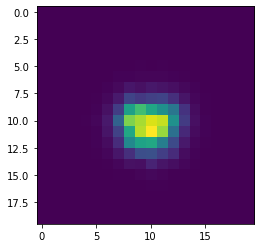

In [92]:
name = 'FRB'
method = 'FFT'
num_phot = int(7.5e5)

sarray = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, '15ms', num_phot, 2), delimiter = ',')
plt.imshow(sarray)

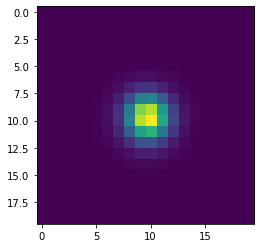

In [17]:
name = 'FRB'
method = 'FFT'
num_phot = int(7.5e5)

sarray = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, '15s', num_phot, 100), delimiter = ',')
plt.imshow(sarray)

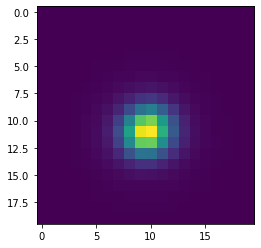

In [16]:
name = 'point_source'
method = 'geom'
num_phot = int(7.5e5)

sarray = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, '15s', num_phot, 130), delimiter = ',')
plt.imshow(sarray)